In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/kodolamacz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kodolamacz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [61]:
from sklearn.model_selection import train_test_split
import re
from multiprocessing import Pool
import nltk
import string
from nltk.tokenize import casual_tokenize,TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.pipeline import Pipeline as Pipeline_imb

In [62]:
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [67]:
import pickle
from wordcloud import WordCloud

In [397]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim import matutils
import pyLDAvis.gensim

In [242]:
pd.set_option('display.max_colwidth',-1)
% matplotlib inline
plt.style.use('seaborn-pastel')
pd.options.display.max_colwidth = -1
np.set_printoptions(3, suppress=True)

## Are 140 characters enough to identify their author? Machine learning, NLP: Text Classification using scikit-learn, python and NLTK.
### Task:
Identify the author of tweet accoring to analysis of tweets's content (with hashtags, urls and personal details cleaned). 


### Dataset from https://www.kaggle.com/speckledpingu/RawTwitterFeeds
### Description:
This is a dataset of **tweets** from various active **scientists** and **personalities** ranging from Donald Trump and Hillary Clinton to Neil deGrasse Tyson. The data was scraped using JavaScript directly off of Twitter's website and has been dumped from JSON into CSV using Pandas read_json and to_csv feature.


**Twitter** is an online news and **social networking service** on which users post and interact with messages known as "tweets". Tweets were originally restricted to 140 characters, but on November 7, 2017, this limit was doubled. 

### 1. Reading data

In [7]:
df = pd.read_csv('Data/famous_tweets/AllTweets.csv',usecols=['text','author','link'])

In [8]:
df.head(5)

,link,text,author
0,/NASA/status/787029214612586496,New software on the @Space_Station will make data communications faster and easier for hundreds of scientists: http://go.nasa.gov/2dQrLto pic.twitter.com/weIfEomT9x,NASA
1,/NASA/status/787008587927281664,READY for Launch! @OrbitalATK's #Antares rocket & cargo ship set to lift off at 8:03pm ET Sunday to @Space_Station: http://go.nasa.gov/2egj5e9 pic.twitter.com/pwB3mYIrrP,NASA
2,/NASA/status/787042156116664320,Rocket launch at 8:03pm ET Sunday to deliver cargo to @Space_Station. Are you in the launch viewing area? More: http://go.nasa.gov/2egB9Vw pic.twitter.com/eKMHk7eHRV,NASA
3,/NASA/status/787284414732472320,What happened this week at NASA? @POTUS outlined space exploration's future. Also highlighted: #WHFrontiers Conference & @NASA_Orion. Watch:pic.twitter.com/4UxeBWVhee,NASA
4,/NASA/status/786934496625102848,Energize! Study makes sure astronauts have energy they need. Watch our @Space_Station update. Q? Use #SpaceToGround. https://youtu.be/oKZvYztlpp4 pic.twitter.com/vo8HUB17Wm,NASA


### 2. Analysis of authors

In [9]:
df.shape

(88625, 3)

In [10]:
df.isnull().sum() # check null values

link      0
text      0
author    0
dtype: int64

In [11]:
df.author.value_counts()

DonaldTrump        17216
NASA               15910
KimKardashian      10688
various            10440
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
ScottKelly         1219 
Name: author, dtype: int64

### 2.1 What are "various" authors?

In [12]:
various_authors = [a[1] for a in df.loc[df.author == 'various','link'].str.split('/')]

In [13]:
df.loc[df.author == 'various','author'] = various_authors

In [14]:
author_stats = df.author.value_counts()

In [15]:
len(author_stats)# there are 2416 authors

2416

In [16]:
author_stats[:15]# we are taking into consideration authors with more than one thousand of tweets

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
datascigeek        667  
chi2innovations    364  
eelrekab           352  
innova_scape       237  
Name: author, dtype: int64

In [17]:
author_names = np.array(author_stats[author_stats > 1000].index)

In [18]:
df = df.loc[df.author.isin(author_names)]

In [19]:
df.author.value_counts()# check

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
Name: author, dtype: int64

In [20]:
print("Dataset contains {} tweets".format(df.shape[0]))

Dataset contains 79757 tweets


In [21]:
print("There are {} authors of more than one thousand tweets. ".format(len(author_names)))

There are 11 authors of more than one thousand tweets. 


### 2.2 Statistics for authors

In [22]:
author_counts = df.author.value_counts()
print(author_counts / author_counts.sum())

DonaldTrump        0.215856
NASA               0.199481
KimKardashian      0.134007
FiveThirtyEight    0.122384
BarackObama        0.086463
RichardDawkins     0.073210
AdamSavage         0.061086
HillaryClinton     0.042078
deGrasseTyson      0.030442
kdnuggets          0.019710
ScottKelly         0.015284
Name: author, dtype: float64


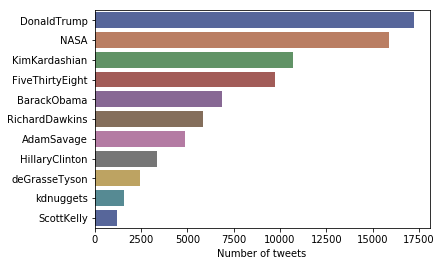

In [23]:
sns.barplot(x = author_counts.values,y = author_names,alpha = 0.7,orient="h",palette='dark')
plt.xlabel('Number of tweets');

### Note: 
Inbalanced dataset with 11 authors and number of tweets ranging from 1.2 thousand up to 17.2 thousand.

### 2.3 Converting author's name to categorical veriable

In [24]:
df.author = df.author.astype('category')

In [25]:
df.author.cat.categories

Index(['AdamSavage', 'BarackObama', 'DonaldTrump', 'FiveThirtyEight',
       'HillaryClinton', 'KimKardashian', 'NASA', 'RichardDawkins',
       'ScottKelly', 'deGrasseTyson', 'kdnuggets'],
      dtype='object')

### 2.4 Statistic for tweets

In [26]:
print('Tweets has on average {} signs.'.format(df.text.apply(lambda x: len(x)).mean()))

Tweets has on average 116.4430081372168 signs.


### 3. Splitting into train and test datasets

In [27]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.author,test_size = 0.2,
                                                 stratify = df.author,random_state = 123)

In [28]:
y_train.value_counts()

DonaldTrump        13773
NASA               12728
KimKardashian      8550 
FiveThirtyEight    7809 
BarackObama        5517 
RichardDawkins     4671 
AdamSavage         3897 
HillaryClinton     2685 
deGrasseTyson      1942 
kdnuggets          1258 
ScottKelly         975  
Name: author, dtype: int64

### 3. Preprocessing

### 3.1  Text cleaning - no hashtags, urls, pictures' links

Removing:
- "#" hashtags,
- "@" at sign,
- urls,
- pictures links


In [29]:
class TweetCleaner(TransformerMixin):
    def __init__(self,process=2):
        self.process = process 
        
    def cleaning_text(self,tweet):
        '''
        removes urls, pictures,# hashtags,@ at signs from tweet
        return cleaned tweet, number of urls, pictures, # hastaags, @ at signs 
        '''
        #urls
        regex = re.compile(r'http[s]*://[\w.\-/\\]+')
        url = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        #pictures
        regex = re.compile(r'pic.*')
        pic = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '#'hashtags
        regex = re.compile(r'#\w+')
        hashtag = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '@'at signs
        regex = re.compile(r'@\w+')
        at_sign = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # multiple whitespaces
        tweet = re.sub(r'\s{2,}','',tweet)

        return tweet,url,pic,hashtag,at_sign
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        pool = Pool(self.process)
        result = pool.map(self.cleaning_text,X)
        pool.close()
        pool.join()
        
        cleaned_tweets = [res[0] for res in result]
        urls = [res[1] for res in result]
        pics = [res[2] for res in result]
        hashtags = [res[3] for res in result]
        at_signs = [res[4] for res in result]
        
        X_out = pd.DataFrame({
            'text':cleaned_tweets,
            'urls':urls,
            'pics':pics,
            'hashtags':hashtags,
            'at_signs':at_signs
        })
        
        return X_out
    

In [30]:
cleaner = TweetCleaner(2)

In [31]:
X_cleaned = cleaner.fit_transform(X_train)

In [32]:
X_cleaned.head()

,text,urls,pics,hashtags,at_signs
0,I willbe releasing the full interview with a guy named Baxteronly to show the bias and stupidity of him and . Clowns!,0,0,0,2
1,Baby boomers use way more drugs than older generations did at their age:,1,1,0,0
2,Hillary Clinton got the biggest post-debate polling bounce:,1,1,0,0
3,Take a 360 video ride with our 10-propeller Greased Lightning plane! Start your flight:,1,1,0,0
4,We don't have a country- if we don't have borders.Video:…,1,1,1,0


### 3.3 Tokenization

In [33]:
class TweetProcessor(TransformerMixin):
    def __init__(self,stopwords,process=2):
        self.process = process
        self.stopwords = stopwords
       
    def processing_text(self,tweet,stopwords,stemmer):
        '''
        removes punctuation, stopwords, converts to stems 
        returns cleaned text, average length of words in tweet and number of words in tweet
        '''
        # remove cappital letters
        tweet = tweet.lower()

        # tokenizer for informal text
        tokens = casual_tokenize(tweet)

        # remove punctuation
        tokens_no_punct = [token for token in tokens if not token in string.punctuation]

        # number of words in tweet
        words_count = len(tokens_no_punct)

        # average length of words in tweet
        token_len = [len(token) for token in tokens_no_punct]
        if len(token_len) > 0 :
            aver_len = np.array(token_len).mean()
        else:
            aver_len = 0

        #remove stopwords
        tokens_no_stopwords = [token for token in tokens_no_punct if not token in stopwords]

        #stemming
        stems = [stemmer.stem(token) for token in tokens_no_stopwords]

        return ' '.join(stems),aver_len,words_count
    
    def add_stopwords(self,words):
        
        for word in words:
            self.stopwords.append(word)

    def fit(self,X,y=None):
        # find text column
        self.key = X.select_dtypes(exclude='number').columns[0]
        return self
    
    def transform(self,X,y=None):
        
        X = X.copy()
        
        X_text = X.pop(self.key)
        
        porter_stemmer = PorterStemmer()
        
        pool = Pool(self.process)
        results = pool.map(partial(self.processing_text,stopwords=self.stopwords,stemmer=porter_stemmer),X_text)
        pool.close()
        pool.join()
        
        processed_tweets = [res[0] for res in results]
        tokens_length = [res[1] for res in results]
        words_count = [res[2] for res in results]
        
        X_out = pd.DataFrame({
            'text':processed_tweets,
            'tokens_length':tokens_length,
            'words_count':words_count,
        })
    
        return pd.concat([X,X_out],axis=1)

In [34]:
stopwords = nltk.corpus.stopwords.words('english')

In [35]:
add_words = ['nasa','adam','savage','barack','obama','donald','trump','hillary','clinton',
             'kim','kardashian','kardashians','de','grasse','tyson','scott','kelly','richard','dawkins',
             'adamsavage','barackobama','donaldtrump','hillaryclinton','kimkardashian','degrassetyson',
             'scottkelly','richarddawkins','fivethirtyeight','kdnuggets']

In [36]:
processor = TweetProcessor(nltk.corpus.stopwords.words('english'),2)

In [37]:
processor.add_stopwords(add_words)

In [38]:
X_proc = processor.fit_transform(X_cleaned)

In [39]:
X_proc.head()

,urls,pics,hashtags,at_signs,text,tokens_length,words_count
0,0,0,0,2,willb releas full interview guy name baxteronli show bia stupid clown,4.476190,21
1,1,1,0,0,babi boomer use way drug older gener age,4.538462,13
2,1,1,0,0,got biggest post-deb poll bounc,6.375000,8
3,1,1,0,0,take 360 video ride 10 propel greas lightn plane start flight,4.733333,15
4,1,1,1,0,countri borders.video …,4.181818,11


### 4. Classification
- To handle imbalanced dataset we try three solutions: undersampling data, weighting classes according to samples size, oversampling data.
- To reduce time needed for tuning hyperparameters, first (except of oversampled dataset), we optimize parameters for TF-IDF vectorizerin conjunction with Naive Bayes classifier, then, with vectorizer parameters set, we check results for three different classifiers and tune their hyperparameters. 

In [40]:
class ItemSelector(BaseEstimator,TransformerMixin):
    def __init__(self,key):
        self.key = key
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        df = X.select_dtypes(include=self.key)
        if df.shape[1] == 1:
            #convert to series
            df = pd.Series(df.values.ravel())
        return df

In [41]:
class ArrayCaster(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X,y=None):
        return np.array(X)

### 4.1 Undersampled data

### 4.1.1 Optimize vectorizer parameters with use of NaiveBayes classifier

In [43]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('caster',ArrayCaster())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler()),
    ('bayes',MultinomialNB())
])

param_bayes = {
    'features__text__vectorizer__min_df':[10,20,50],
    'features__text__vectorizer__max_df':[0.2,0.3,0.5,0.7]
}

grid = GridSearchCV(estimator=pipe,
                   param_grid = param_bayes,
                   scoring='f1_micro',
                   n_jobs=2,
                   cv=KFold(5,shuffle=True))

grid.fit(X_proc,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector1', ItemSelector(key='object')), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...      return_indices=False)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'features__text__vectorizer__min_df': [10, 20, 50], 'features__text__vectorizer__max_df': [0.2, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [44]:
grid.best_params_

{'features__text__vectorizer__max_df': 0.5,
 'features__text__vectorizer__min_df': 50}

In [45]:
max_df = grid.best_params_['features__text__vectorizer__max_df']
min_df = grid.best_params_['features__text__vectorizer__min_df']

In [46]:
grid.best_score_

0.584719065903926

### 4.1.2 Apply vectorizer parameters

In [47]:
pipe_under = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler())#SMOTE(k_neighbors=3,m_neighbors=7))
])

X_res,y_res = pipe_under.fit_sample(X_proc,y_train)

In [48]:
X_res.shape

(10725, 1831)

In [49]:
y_res.shape

(10725,)

In [50]:
pd.Series(y_res).value_counts()

DonaldTrump        975
FiveThirtyEight    975
kdnuggets          975
RichardDawkins     975
deGrasseTyson      975
KimKardashian      975
NASA               975
HillaryClinton     975
BarackObama        975
AdamSavage         975
ScottKelly         975
dtype: int64

### 4.1.3 Find optimal classifier

In [51]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1,1.0]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0,10.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [52]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=-1,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_res,y_res)
    y_pred = grid.predict(X_res)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_res,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Undersampled' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 1.0}
0.6243356643356643
                 precision    recall  f1-score   support

     AdamSavage       0.67      0.64      0.65       975
    BarackObama       0.76      0.74      0.75       975
    DonaldTrump       0.79      0.71      0.75       975
FiveThirtyEight       0.79      0.79      0.79       975
 HillaryClinton       0.66      0.71      0.69       975
  KimKardashian       0.75      0.71      0.73       975
           NASA       0.79      0.85      0.82       975
 RichardDawkins       0.81      0.79      0.80       975
     ScottKelly       0.68      0.78      0.73       975
  deGrasseTyson       0.84      0.70      0.76       975
      kdnuggets       0.80      0.92      0.86       975

    avg / total       0.76      0.76      0.76     10725

LogistiRegression
{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l2'}
0.6642424242424242
                 precision    recall  f1-score   support

     AdamSavage       0.73      0.60      0.66       975
    Barac

### 4.2 Weighted classes - weights according to classes' cardinality, the most numerous class - weight =  1.0 

### 4.2.1 Optimize vectorizer parameters with use of NaiveBayes classifier

In [42]:
max_count = y_train.value_counts().max()

In [43]:
weights_author = max_count / y_train.value_counts()

In [44]:
dict_weights = {key:value for key,value in zip(weights_author.index,weights_author.values)}

In [45]:
weights = [dict_weights[y] for y in y_train]

In [46]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('caster',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler()),
    ('bayes',MultinomialNB())
])

param_bayes = {
    'features__text__vectorizer__min_df':[10,20,50],
    'features__text__vectorizer__max_df':[0.2,0.3,0.5,0.7]
}

grid = GridSearchCV(estimator=pipe,
                   param_grid = param_bayes,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=KFold(5,shuffle=True))

grid.fit(X_proc,y_train,weights)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector1', ItemSelector(key='object')), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...      return_indices=False)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__text__vectorizer__min_df': [10, 20, 50], 'features__text__vectorizer__max_df': [0.2, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [47]:
grid.best_params_

{'features__text__vectorizer__max_df': 0.7,
 'features__text__vectorizer__min_df': 10}

In [48]:
max_df = grid.best_params_['features__text__vectorizer__max_df']
min_df = grid.best_params_['features__text__vectorizer__min_df']

In [49]:
grid.best_score_

0.656782383825719

### 4.2.2 Apply vectorizer parameters

In [50]:
pipe_weights = Pipeline([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
])

X_proc2 = pipe_weights.fit_transform(X_proc)

In [55]:
X_proc2.shape

(63805, 5311)

In [56]:
X_proc.shape

(63805, 7)

In [57]:
y_train.shape

(63805,)

In [58]:
len(weights)

63805

### 4.2.3 Find optimal classifier

In [59]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1,1.0]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0,10.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [68]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=2,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_proc2,y_train,weights)
    y_pred = grid.predict(X_proc2)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_train,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Weighted' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 0.1}
0.7513517749392681
                 precision    recall  f1-score   support

     AdamSavage       0.79      0.56      0.65      3897
    BarackObama       0.78      0.73      0.75      5517
    DonaldTrump       0.75      0.91      0.82     13773
FiveThirtyEight       0.84      0.83      0.83      7809
 HillaryClinton       0.83      0.38      0.52      2685
  KimKardashian       0.80      0.83      0.81      8550
           NASA       0.82      0.95      0.88     12728
 RichardDawkins       0.88      0.81      0.84      4671
     ScottKelly       0.95      0.33      0.49       975
  deGrasseTyson       0.94      0.54      0.69      1942
      kdnuggets       0.97      0.63      0.77      1258

    avg / total       0.81      0.81      0.80     63805

LogistiRegression
{'C': 10.0, 'multi_class': 'ovr', 'penalty': 'l2'}
0.8078990674712013
                 precision    recall  f1-score   support

     AdamSavage       0.84      0.71      0.77      3897
    Bara

### + SVD

In [64]:
pipe_weights2 = Pipeline([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words)),
                ('svd',TruncatedSVD(n_components=2000)),
                ('scaler',MinMaxScaler())
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
])

X_proc3 = pipe_weights2.fit_transform(X_proc)

In [65]:
X_proc.shape

(63805, 7)

In [66]:
X_proc3.shape

(63805, 2006)

In [67]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=2,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_proc3,y_train,weights)
    y_pred = grid.predict(X_proc3)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_train,y_pred=y_pred))
    
    #saving model
    model_name = './Models/WeightedSVD' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 0.1}
0.33539691246767495
                 precision    recall  f1-score   support

     AdamSavage       0.00      0.00      0.00      3897
    BarackObama       0.00      0.00      0.00      5517
    DonaldTrump       0.35      0.92      0.51     13773
FiveThirtyEight       0.00      0.00      0.00      7809
 HillaryClinton       0.00      0.00      0.00      2685
  KimKardashian       0.00      0.00      0.00      8550
           NASA       0.32      0.69      0.44     12728
 RichardDawkins       0.00      0.00      0.00      4671
     ScottKelly       0.00      0.00      0.00       975
  deGrasseTyson       0.00      0.00      0.00      1942
      kdnuggets       0.00      0.00      0.00      1258

    avg / total       0.14      0.34      0.20     63805

LogistiRegression


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

### 4.2 Oversampled data

### 4.2.1 Apply vectorizer parameters (apply optimal parameters obtained for weighted classes )

In [139]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',SMOTE(k_neighbors=3,m_neighbors=7))
])

X_res,y_res = pipe.fit_sample(X_proc,y_train)

In [140]:
X_res.shape

(151503, 5342)

In [141]:
y_res.shape

(151503,)

### 4.3.2 Find optimal classifier

In [142]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [144]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=-1,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_res,y_res)
    y_pred = grid.predict(X_res)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_res,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Oversampled_' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes


KeyboardInterrupt: 

### 5.Best model - Logistic regresion with weighted classes

In [175]:
model_name = './Models/WeightedLogistiRegression.p'
with open(model_name,'rb') as f:
    best_model = pickle.load(f)

In [176]:
y_pred = best_model.predict(X_proc2)
print(classification_report(y_true=y_train,y_pred=y_pred))

                 precision    recall  f1-score   support

     AdamSavage       0.85      0.72      0.78      3897
    BarackObama       0.88      0.87      0.88      5517
    DonaldTrump       0.90      0.94      0.92     13773
FiveThirtyEight       0.92      0.95      0.94      7809
 HillaryClinton       0.89      0.71      0.79      2685
  KimKardashian       0.87      0.92      0.89      8550
           NASA       0.95      0.97      0.96     12728
 RichardDawkins       0.93      0.91      0.92      4671
     ScottKelly       0.89      0.69      0.78       975
  deGrasseTyson       0.94      0.83      0.88      1942
      kdnuggets       0.96      0.94      0.95      1258

    avg / total       0.91      0.91      0.91     63805



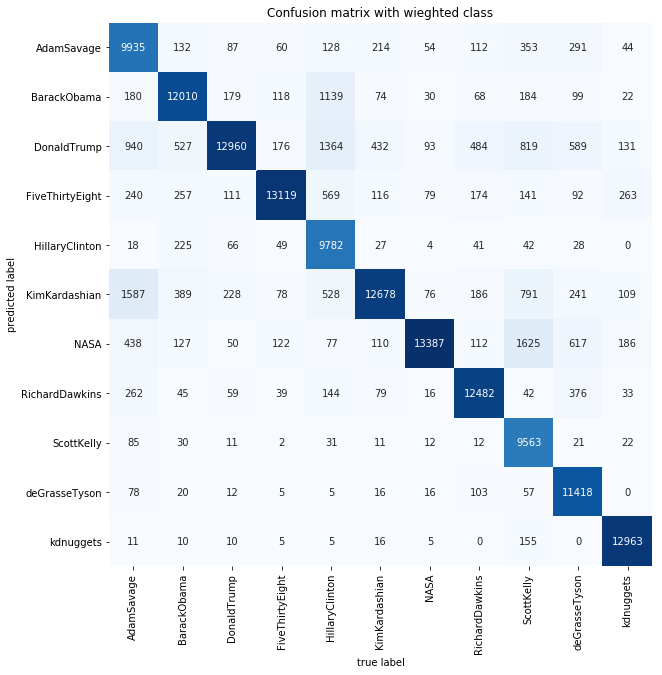

In [191]:
cm = confusion_matrix(y_true=y_train,y_pred=y_pred,sample_weight=weights)

plt.figure(figsize=(10,10))
sns.heatmap(cm.T,square=True,annot=True,fmt='.0f',cbar=False,cmap='Blues',
            xticklabels=df.author.cat.categories,yticklabels=df.author.cat.categories)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix with wieghted class')
plt.show()

### 6. Model evaluation on test data

### 6.1 Initial processing of test data

In [178]:
X_cleaned_test = cleaner.transform(X_test)

In [179]:
X_proc_test = processor.transform(X_cleaned_test)

In [180]:
X_proc2_test = pipe_weights.transform(X_proc_test)

In [181]:
weights_test = [dict_weights[y] for y in y_test]

In [186]:
len(weights_test)

15952

In [188]:
X_proc2.shape

(63805, 5334)

### 6.2 Model evaluation

In [189]:
y_pred_test = best_model.predict(X_proc2_test)
print(classification_report(y_true=y_test,y_pred=y_pred_test))

                 precision    recall  f1-score   support

     AdamSavage       0.68      0.54      0.60       975
    BarackObama       0.79      0.78      0.78      1379
    DonaldTrump       0.82      0.89      0.85      3443
FiveThirtyEight       0.85      0.89      0.87      1952
 HillaryClinton       0.71      0.54      0.61       671
  KimKardashian       0.78      0.85      0.81      2138
           NASA       0.91      0.95      0.93      3182
 RichardDawkins       0.83      0.78      0.81      1168
     ScottKelly       0.68      0.44      0.54       244
  deGrasseTyson       0.78      0.60      0.68       486
      kdnuggets       0.92      0.83      0.87       314

    avg / total       0.82      0.82      0.82     15952



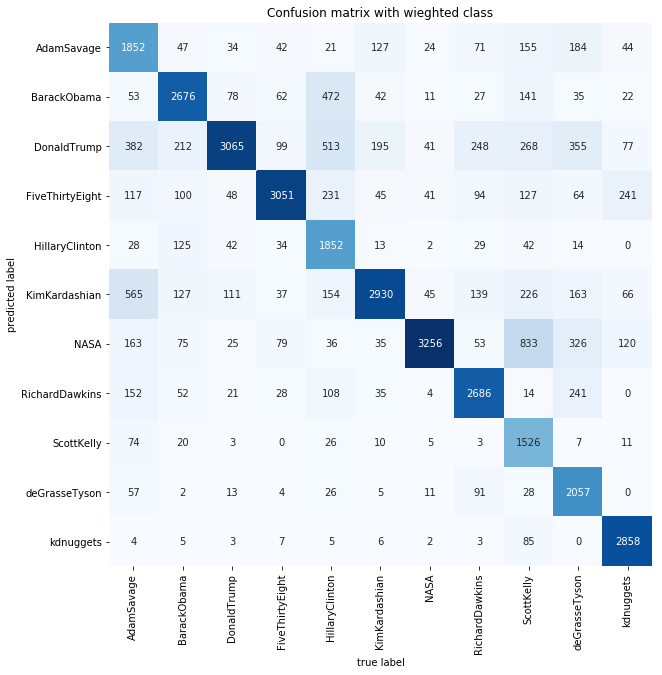

In [192]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_test,sample_weight=weights_test)

plt.figure(figsize=(10,10))
sns.heatmap(cm.T,square=True,annot=True,fmt='.0f',cbar=False,cmap='Blues',
            xticklabels=df.author.cat.categories,yticklabels=df.author.cat.categories)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix with wieghted class')
plt.show()

### 7. Analysis of wrongly classified tweets

In [193]:
y_test = y_test.reset_index()
y_test.drop('index',axis=1,inplace=True)
X_test = X_test.reset_index()
X_test.drop('index',axis=1,inplace=True)

In [195]:
df_res = pd.concat([X_test,y_test],axis=1)

In [196]:
df_res['author_pred'] = y_pred_test

In [204]:
df_res.loc[(df_res['author'] != df_res['author_pred'])].head(10)

,text,author,author_pred
0,This is AMAZING:https://vimeo.com/157937153,AdamSavage,KimKardashian
1,@karimnanavour He has every right to express whatever he wants. And I have every right not to waste my time reading it.,RichardDawkins,DonaldTrump
4,"So, so good.http://youtu.be/PZbqAMEwtOE",AdamSavage,KimKardashian
8,Would seem that plane landed short of runway in San Francisco!,DonaldTrump,AdamSavage
20,"The loss of lives to terrorism is tragic and abhorrent, in Nigeria as in Europe. We must all come together to end this scourge. -H",HillaryClinton,DonaldTrump
22,Paleoclimate data show the 'dangerous' level of global warming is less than we thought: Hansen @theAGU. http://go.nasa.gov/u03v8h #agu11,NASA,DonaldTrump
32,"Hey everyone attending tonigh at the Swedish American in SF! Let's make @w00tstock a trending topic. 3,2,1...GO!",AdamSavage,KimKardashian
37,Departing for #GOPDebate. Let's #MakeAmericaGreatAgain! https://www.facebook.com/DonaldTrump/posts/10156417157260725:0 …pic.twitter.com/Bwyu1U3rHU,DonaldTrump,FiveThirtyEight
67,You can't fight what you don't believe exists. Climate change is real and we must meet this challenge. #EarthDay -H,HillaryClinton,BarackObama
71,"""It wastes America's time ... You guys are all paying for it as taxpayers.""—President Obama on House leadership's lawsuit",BarackObama,DonaldTrump


## What they are talking about? Machine learning, NLP: Topic modeling
### Task:
Identify the author of tweet accoring to analysis of tweets's content (with hashtags, urls and personal details cleaned). 

### 1.1 The most frequent words for each author - Word Clouds

In [114]:
def most_frequent_words(X,k):
    pipe_tf = Pipeline([
    ('selector1',ItemSelector('object')),
    ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
    ])
    X_proc_tf = pipe_tf.fit_transform(X)
    
    dtm_sum = np.array(X_proc_tf.sum(axis=0))[0]
    
    words_counter = np.argsort(dtm_sum)
    words_counter = words_counter[::-1]
        
    top_words_indices = words_counter[:k]
    words = np.array(pipe_tf.named_steps['vectorizer'].get_feature_names())
    return words[top_words_indices]

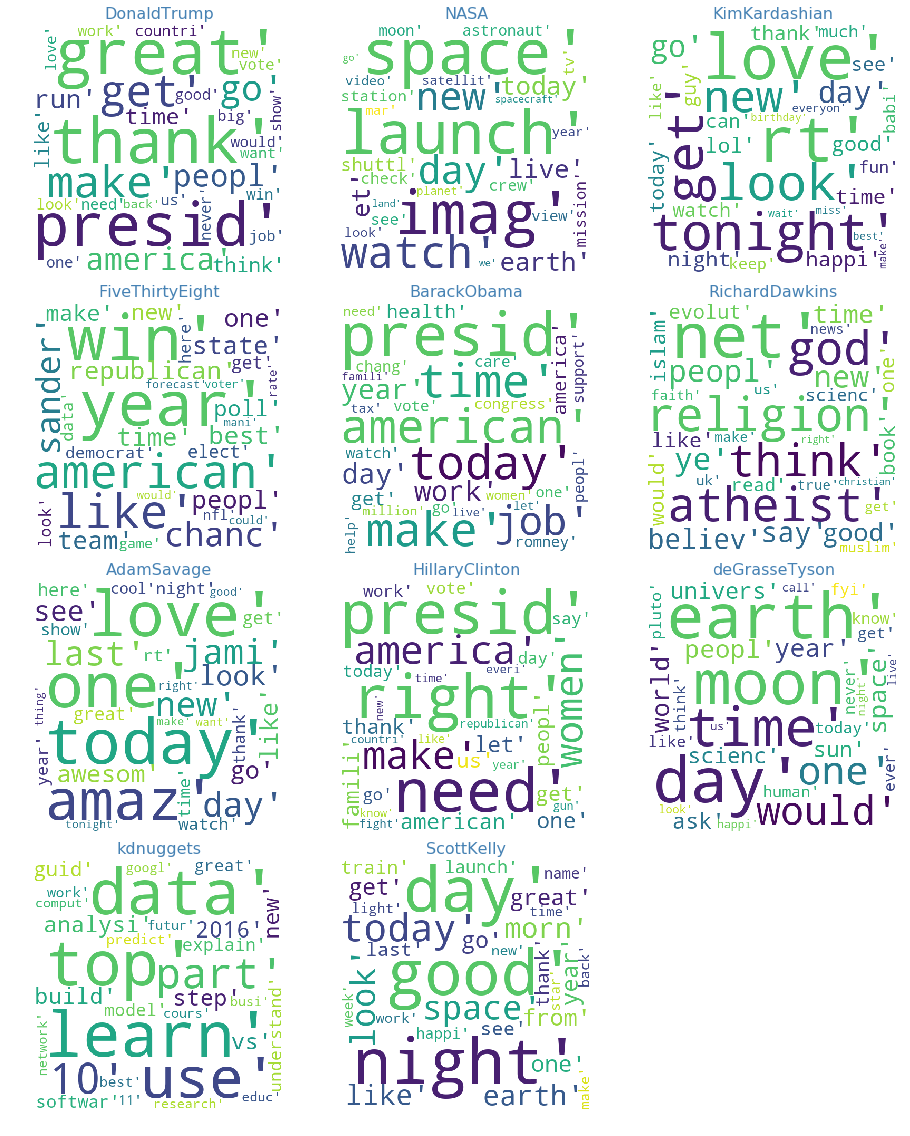

In [191]:
k = 30
plt.figure(figsize=(16,20))
plt.subplots_adjust(wspace = 0.1,hspace=0.1)
for i,name in enumerate(author_names):
    X_proc_author = X_proc[y_train.reset_index().drop('index',axis=1).author == name]
    
    wordcloud = WordCloud(
        width=480, 
        height=480,
        background_color='white',
        max_words=80,
        max_font_size=120, 
        random_state=42,
        scale = 1
    ).generate(str(most_frequent_words(X_proc_author,k)))
    
    ax= plt.subplot(4,3 ,i+1)
    plt.title(name,fontsize=16,color='steelblue')
    plt.imshow(wordcloud)
    plt.axis('off')

In [200]:
def top_words(matrix,vectorizer,k):
    
    words = np.array(vectorizer.get_feature_names())
    top_words = []
    
    for art in range(matrix.shape[0]):

        words_counter =  matrix.getrow(art).toarray()[0]

        words_counter = np.argsort(words_counter)
        words_counter = words_counter[::-1]
        
        top_words_indices = words_counter[:k]
        top_document_words = words[top_words_indices]
        
        
        top_words.append(top_document_words) 
        
    return np.array(top_words)

In [379]:
pipe_weights2 = Pipeline([
    ('selector1',ItemSelector('object')),
    ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words)),
    ('svd',TruncatedSVD(n_components=300))
])

X_proc3 = pipe_weights2.fit_transform(X_proc)

In [380]:
#5305 tokens

In [381]:
X_proc3.shape

(63805, 300)

In [382]:
author_names

array(['DonaldTrump', 'NASA', 'KimKardashian', 'FiveThirtyEight',
       'BarackObama', 'RichardDawkins', 'AdamSavage', 'HillaryClinton',
       'deGrasseTyson', 'kdnuggets', 'ScottKelly'], dtype=object)

In [418]:
author_topic = []
for i,name in enumerate(author_names):
    X_proc_author = X_proc3[y_train.reset_index().drop('index',axis=1).author == name]
    print(X_proc_author.shape)
    author_topic.append(X_proc_author.mean(axis=0))

(13773, 300)
(12728, 300)
(8550, 300)
(7809, 300)
(5517, 300)
(4671, 300)
(3897, 300)
(2685, 300)
(1942, 300)
(1258, 300)
(975, 300)


In [384]:
# k najczęstszych tematów w tweetach danego autora

In [424]:
author_topic = []
for i,name in enumerate(author_names):
    X_proc_author = X_proc3[y_train.reset_index().drop('index',axis=1).author == name]
    print(X_proc_author.shape)
    
    #for each tweet of an author topics are sorted (most important up to least important)
    topic_sorted = -np.sort(-X_proc_author,axis=1)
    
    
    #author_topic.append(X_proc_author.mean(axis=0))

(13773, 300)
(12728, 300)
(8550, 300)
(7809, 300)
(5517, 300)
(4671, 300)
(3897, 300)
(2685, 300)
(1942, 300)
(1258, 300)
(975, 300)


In [425]:
topic_sorted[10,:]

array([ 0.259,  0.155,  0.124,  0.119,  0.111,  0.109,  0.108,  0.097,
        0.09 ,  0.078,  0.076,  0.072,  0.069,  0.067,  0.066,  0.065,
        0.064,  0.064,  0.062,  0.06 ,  0.059,  0.057,  0.056,  0.052,
        0.049,  0.047,  0.046,  0.046,  0.045,  0.045,  0.044,  0.04 ,
        0.04 ,  0.04 ,  0.039,  0.038,  0.037,  0.036,  0.035,  0.034,
        0.034,  0.032,  0.032,  0.032,  0.031,  0.03 ,  0.03 ,  0.03 ,
        0.029,  0.029,  0.028,  0.027,  0.027,  0.026,  0.025,  0.025,
        0.024,  0.024,  0.023,  0.022,  0.021,  0.021,  0.019,  0.018,
        0.018,  0.018,  0.017,  0.017,  0.017,  0.016,  0.016,  0.016,
        0.015,  0.015,  0.015,  0.015,  0.015,  0.015,  0.015,  0.014,
        0.014,  0.014,  0.013,  0.013,  0.012,  0.011,  0.011,  0.011,
        0.011,  0.01 ,  0.01 ,  0.009,  0.009,  0.009,  0.009,  0.009,
        0.009,  0.009,  0.009,  0.009,  0.008,  0.008,  0.007,  0.007,
        0.007,  0.007,  0.007,  0.007,  0.006,  0.006,  0.006,  0.006,
      

In [385]:
k=10
k_topics = []
for i,name in enumerate(author_names):
    print(name)
    k_topics.append(np.argsort(author_topic[i])[::-1][:k])
    print(k_topics[i])

DonaldTrump
[  0   1  39 133  50  93 162  45  25 174]
NASA
[ 0  2  7  9 37  4  5 34 60  6]
KimKardashian
[ 0  2  3 18 19  8 27 62 15 21]
FiveThirtyEight
[ 0 36 24 21 31 26 10 48  3 68]
BarackObama
[ 0  5  4  3  1 20 11 27 42 67]
RichardDawkins
[  0  75  86  97 129  38  16  84  39 132]
AdamSavage
[ 0  2 69 18 38  3 42  8 10 62]
HillaryClinton
[ 0 38 67  1 10  3 25 66 19 42]
deGrasseTyson
[  0  37   9  34  10  11   2  54 154  31]
kdnuggets
[  0  75 154 136 150 139  83 142  26 137]
ScottKelly
[ 0  2  8  9  5 12 13 54 16 62]


In [386]:
k_topics

[array([  0,   1,  39, 133,  50,  93, 162,  45,  25, 174]),
 array([ 0,  2,  7,  9, 37,  4,  5, 34, 60,  6]),
 array([ 0,  2,  3, 18, 19,  8, 27, 62, 15, 21]),
 array([ 0, 36, 24, 21, 31, 26, 10, 48,  3, 68]),
 array([ 0,  5,  4,  3,  1, 20, 11, 27, 42, 67]),
 array([  0,  75,  86,  97, 129,  38,  16,  84,  39, 132]),
 array([ 0,  2, 69, 18, 38,  3, 42,  8, 10, 62]),
 array([ 0, 38, 67,  1, 10,  3, 25, 66, 19, 42]),
 array([  0,  37,   9,  34,  10,  11,   2,  54, 154,  31]),
 array([  0,  75, 154, 136, 150, 139,  83, 142,  26, 137]),
 array([ 0,  2,  8,  9,  5, 12, 13, 54, 16, 62])]

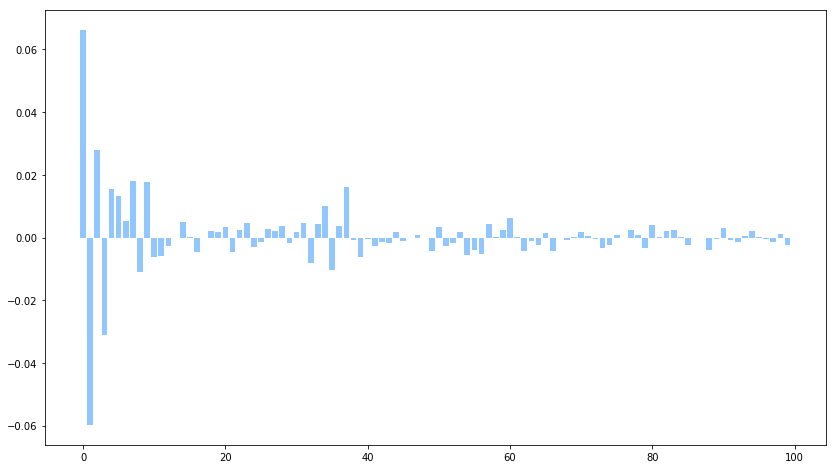

In [387]:
max_ = 100
plt.figure(figsize=(14,8))
plt.bar(range(0,max_),author_topic[1][:max_]);

In [389]:
np.min(author_topic)

-0.06062659865669062

In [390]:
np.max(author_topic)

0.10547509688844144

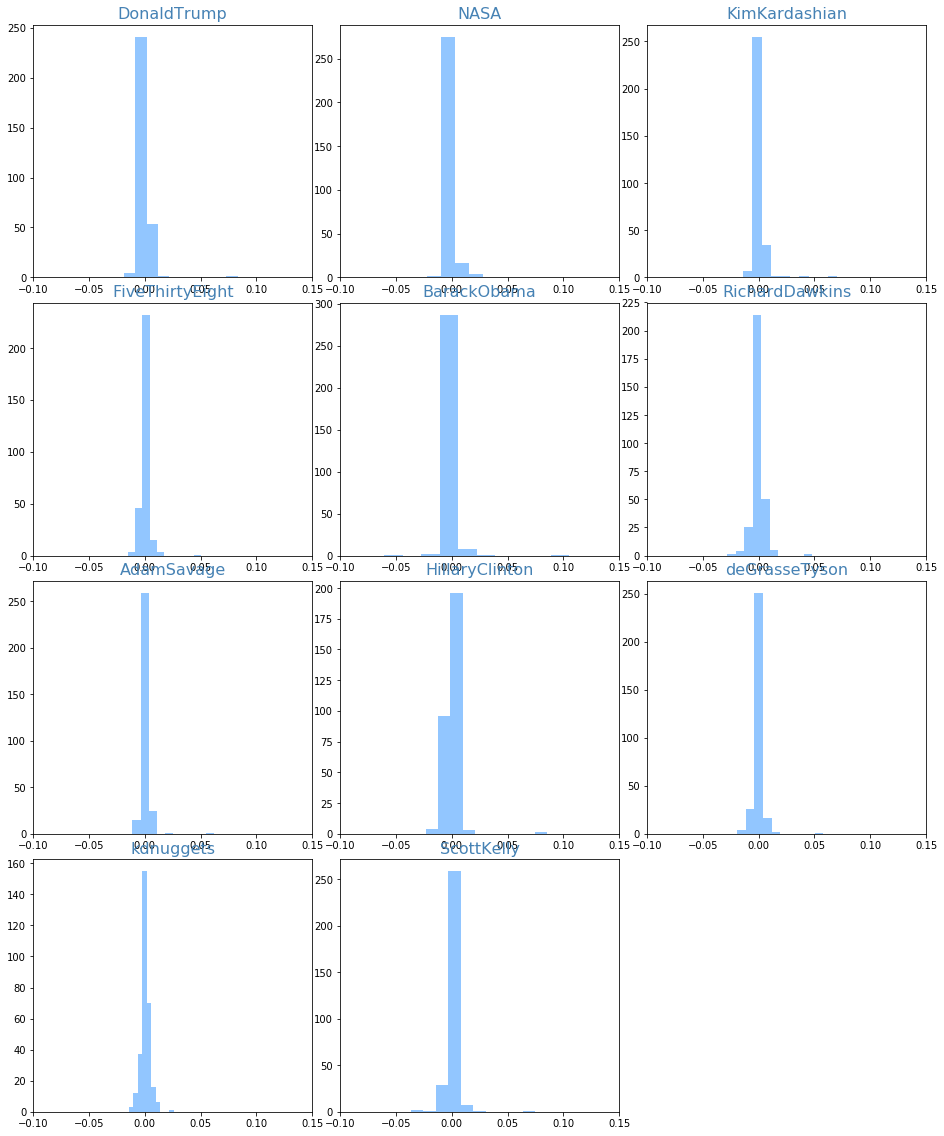

In [391]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(wspace = 0.1,hspace=0.1)
for i,name in enumerate(author_names):
    ax= plt.subplot(4,3 ,i+1)
    plt.title(name,fontsize=16,color='steelblue')
    plt.hist(author_topic[i])
    plt.xlim(-0.1,0.15)

In [392]:
svd = pipe_weights2.named_steps['svd']

In [393]:
svd.explained_variance_ratio_.sum()

0.33757916713540426

In [394]:
svd.components_.shape

(300, 5305)

In [395]:
vectorizer = pipe_weights2.named_steps['vectorizer']

In [396]:
#Top words in each topic
k=8
words = np.array(vectorizer.get_feature_names())
for ind,topic in enumerate(svd.components_):
    indexes = np.argsort(topic)
    indexes = indexes[::-1]
    top_words_indices = indexes[:k]

    print('topic{}{}'.format(ind,words[top_words_indices]))
    #print(topic[indexes[:k]])
# each topic is a linear combiantations of terms

topic0['presid' 'thank' 'great' 'day' 'love' 'get' 'make' 'go']
topic1['thank' 'love' 'presid' 'great' 'america' 'run' 'make' 'need']
topic2['love' 'thank' 'day' 'new' 'space' 'happi' 'watch' 'launch']
topic3['love' 'presid' 'rt' 'happi' 'look' 'much' 'one' 'like']
topic4['watch' 'presid' 'live' 'love' 'et' 'launch' 'tv' 'space']
topic5['day' 'presid' 'imag' 'happi' 'space' 'love' 'birthday' 'thank']
topic6['great' 'make' 'america' 'love' 'watch' 'day' 'space' 'live']
topic7['new' 'space' 'year' 'york' 'check' 'time' 'station' 'shuttl']
topic8['night' 'new' 'good' 'last' 'watch' 'look' 'tonight' 'presid']
topic9['look' 'space' 'like' 'shuttl' 'station' 'one' 'know' 'night']
topic10['happi' 'birthday' 'watch' 'today' 'one' 'year' 'like' 'look']
topic11['time' 'today' 'year' 'night' 'last' 'happi' 'birthday' 'one']
topic12['go' 'today' 'good' 'happi' 'birthday' 'launch' 'year' 'let']
topic13['today' 'get' 'look' 'good' 'work' 'readi' 'morn' 'job']
topic14['happi' 'get' 'birthday' 'space'

## LDA

In [470]:
pipe = Pipeline([
    ('selector1',ItemSelector('object')),
    ('vectorizer',CountVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
])

dtm = pipe.fit_transform(X_proc)

In [471]:
dtm

<63805x5305 sparse matrix of type '<class 'numpy.int64'>'
	with 472541 stored elements in Compressed Sparse Row format>

In [472]:
corpus = matutils.Sparse2Corpus(dtm,documents_columns=False)# by default documents in columns

In [498]:
len(corpus)

63805

In [473]:
dictionary = vectorizer.get_feature_names()

In [474]:
len(dictionary)

5305

In [477]:
dictionary_dict = {i:j for i,j in enumerate(dictionary)}

In [478]:
dictionary = corpora.Dictionary.from_corpus(corpus=corpus,id2word=dictionary_dict)

In [671]:
top_nmb = 20

In [672]:
lda_model = LdaModel(corpus=corpus,id2word=dictionary,num_topics=top_nmb,alpha='auto',eta='auto')

In [666]:
lda_model.alpha

array([0.084, 0.079, 0.075, 0.077, 0.075, 0.074, 0.083, 0.091, 0.085,
       0.079, 0.079, 0.077, 0.11 , 0.089, 0.096, 0.075, 0.075, 0.075,
       0.083, 0.081], dtype=float32)

In [667]:
lda_model.eta

array([0.037, 0.125, 0.024, ..., 0.033, 0.024, 0.021], dtype=float32)

In [531]:
# dla każedego autora zsumować wagi tematów i policzyć z nich średnią, posortować i zobaczymy które tematy występują najczęściej 
# u którego autora

In [539]:
len(corpus)

63805

In [540]:
len(y_train)

63805

In [621]:
# dla każdego autora policz średnie wagi dla każdego tematu

In [668]:
y_train_df = pd.DataFrame(y_train.reset_index().drop('index',axis=1))
author_topics = []
for i,name in enumerate(author_names):
    indexes = np.array(y_train_df.loc[y_train_df.author == name].index)
    topics_values = np.array([
        [topic_value[1] for topic_value in lda_model.get_document_topics(corpus[index],minimum_probability=0)]
        for index in indexes])
    author_topics.append(topics_values.mean(axis=0))                          

In [622]:
# k najpopularniejszych tematów dla każdego autora

In [669]:
k=10
k_topics = []
for i,name in enumerate(author_names):
    print(name)
    k_topics.append(np.argsort(author_topics[i])[::-1][:k])
    print(k_topics[i])

DonaldTrump
[12 13  7  0 18 14 17  3  8  6]
NASA
[19 11 10  1  8 14 16  0 15  6]
KimKardashian
[14  4  9 13 17  8 12  5 15  2]
FiveThirtyEight
[12  7  6  1 13 18  2  3 17 14]
BarackObama
[12 13  3  0  7 18 16  2 14  9]
RichardDawkins
[18  7  6  2 12 13 14  5  4  3]
AdamSavage
[14  4  8 13  9 18 17  7 15 12]
HillaryClinton
[12 13  7  3 18  2  0  6 16 14]
deGrasseTyson
[ 8  7 10 13 15  0 12 17 14 18]
kdnuggets
[ 6 11 12 18 17  9  2  0 10  1]
ScottKelly
[ 6 14 11  8 19 10 12 13  1  4]


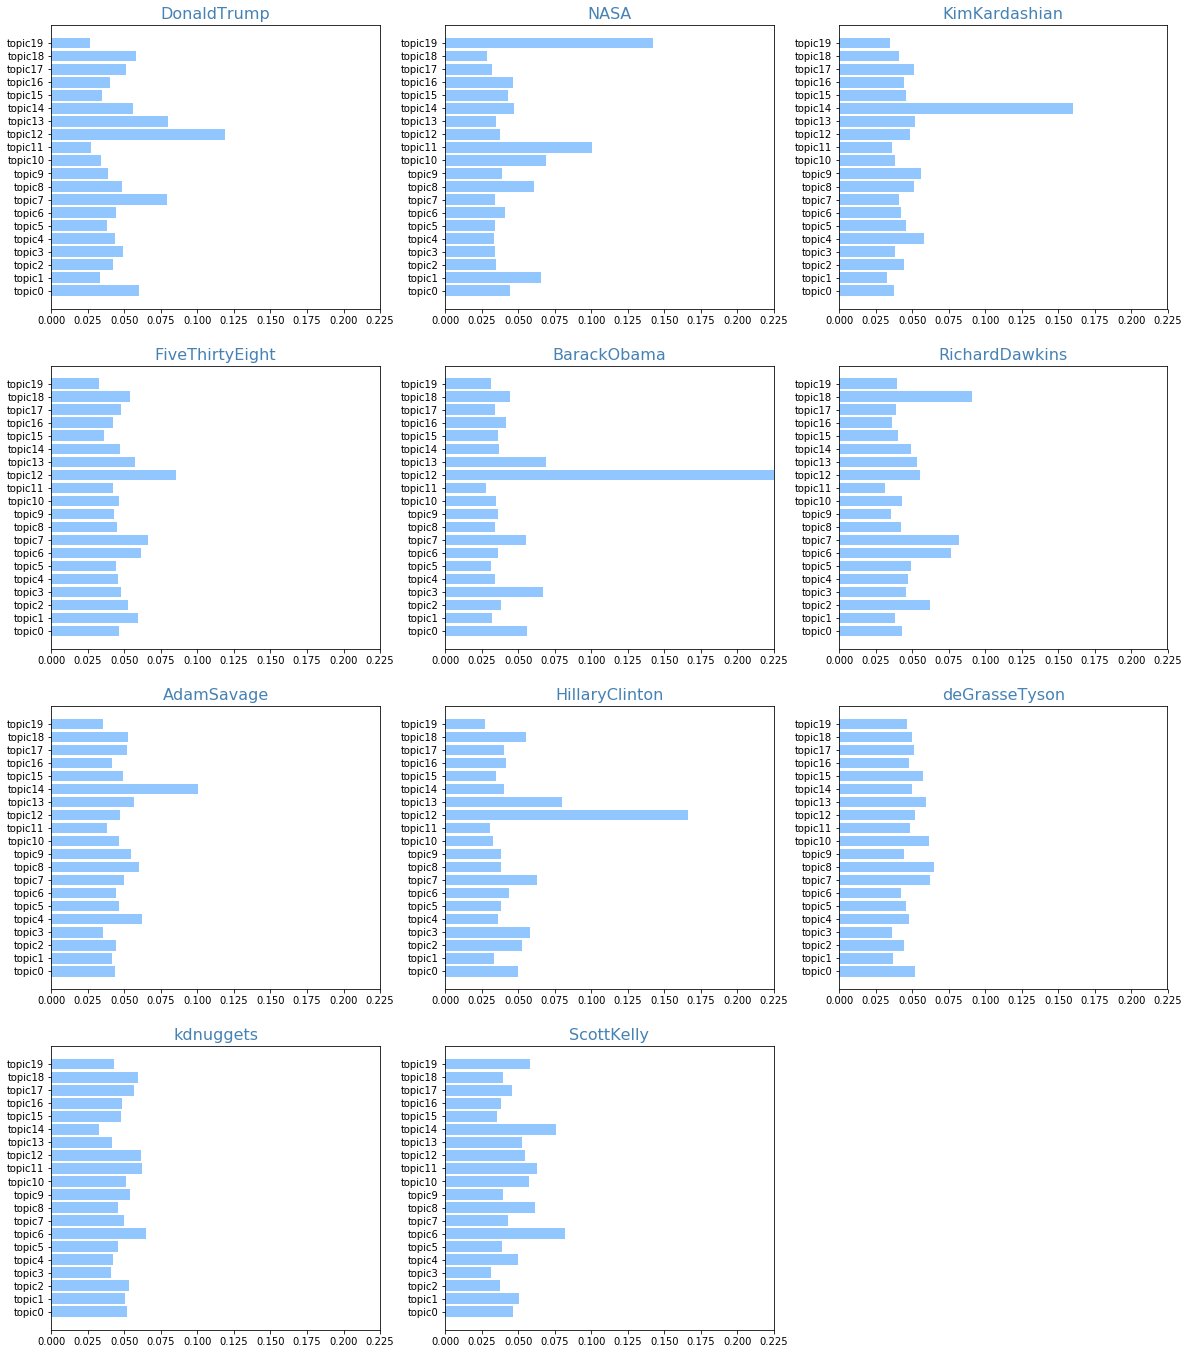

In [673]:
max_ = np.max(author_topics)
plt.figure(figsize=(20,24))
plt.subplots_adjust(wspace = 0.2,hspace=0.2)
for i,name in enumerate(author_names):
    ax= plt.subplot(4,3 ,i+1)
    plt.title(name,fontsize=16,color='steelblue')
    plt.barh(['topic{}'.format(i) for i in range(0,top_nmb)],author_topics[i])
    plt.xlim(0,max_);

In [674]:
[(dictionary[term_value[0]],term_value[1]) for term_value in lda_model.get_topic_terms(6)]

[('miss', 0.02990581),
 ('name', 0.02421033),
 ('fire', 0.021419762),
 ('celebr', 0.016507799),
 ('left', 0.015571869),
 ('china', 0.015420792),
 ('oh', 0.015163776),
 ('global', 0.011712864),
 ('without', 0.010799923),
 ('rubio', 0.010006451)]

In [532]:
for i in range(0,10):#range(len(corpus)):
    doc_topics = lda_model.get_document_topics(corpus[i],minimum_probability=0)
    print(doc_topics)

[(0, 0.017612383), (1, 0.015791042), (2, 0.12114943), (3, 0.14602853), (4, 0.013261711), (5, 0.4479939), (6, 0.01667956), (7, 0.014356284), (8, 0.01367246), (9, 0.19345471)]
[(0, 0.021943724), (1, 0.17160122), (2, 0.4053015), (3, 0.02003263), (4, 0.1466589), (5, 0.018447857), (6, 0.020584), (7, 0.16298361), (8, 0.01685574), (9, 0.015590839)]
[(0, 0.024403077), (1, 0.022050343), (2, 0.022007005), (3, 0.30259573), (4, 0.018479532), (5, 0.22594376), (6, 0.1943368), (7, 0.020030694), (8, 0.019092789), (9, 0.15106024)]
[(0, 0.016014561), (1, 0.014335226), (2, 0.014319584), (3, 0.18535559), (4, 0.33227572), (5, 0.013689984), (6, 0.015224109), (7, 0.14168812), (8, 0.25551954), (9, 0.011577593)]
[(0, 0.0519009), (1, 0.046278004), (2, 0.046259657), (3, 0.32528293), (4, 0.039065633), (5, 0.04405013), (6, 0.32699865), (7, 0.042421807), (8, 0.040427804), (9, 0.037314437)]
[(0, 0.017435476), (1, 0.015663134), (2, 0.11508173), (3, 0.22825876), (4, 0.42082328), (5, 0.14523828), (6, 0.016691169), (7, 

In [533]:
lda_model.print_topics(num_topics=10,num_words=8)

[(0,
  '0.022*"good" + 0.019*"night" + 0.018*"look" + 0.015*"last" + 0.013*"like" + 0.010*"day" + 0.009*"time" + 0.008*"never"'),
 (1,
  '0.039*"love" + 0.015*"rt" + 0.013*"everyon" + 0.012*"one" + 0.012*"can" + 0.010*"thank" + 0.009*"best" + 0.009*"wait"'),
 (2,
  '0.019*"work" + 0.019*"presid" + 0.017*"think" + 0.014*"make" + 0.012*"famili" + 0.011*"american" + 0.011*"go" + 0.010*"women"'),
 (3,
  '0.028*"watch" + 0.024*"live" + 0.016*"et" + 0.015*"launch" + 0.015*"tv" + 0.015*"new" + 0.015*"today" + 0.013*"day"'),
 (4,
  '0.025*"happi" + 0.021*"day" + 0.016*"moon" + 0.015*"mar" + 0.015*"satellit" + 0.014*"imag" + 0.012*"birthday" + 0.010*"view"'),
 (5,
  '0.013*"make" + 0.012*"new" + 0.011*"tweet" + 0.010*"person" + 0.010*"fun" + 0.008*"time" + 0.007*"great" + 0.007*"thought"'),
 (6,
  '0.027*"presid" + 0.020*"thank" + 0.019*"win" + 0.016*"vote" + 0.015*"peopl" + 0.014*"get" + 0.014*"great" + 0.012*"run"'),
 (7,
  '0.016*"year" + 0.013*"presid" + 0.009*"us" + 0.009*"like" + 0.009*"n

In [534]:
pyLDAvis.enable_notebook()

In [535]:
# topics are sorted from most to least popular! the order of topics is changed
pyLDAvis.gensim.prepare(lda_model,corpus=corpus_sparse,dictionary=dictionary_sparse)

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.114452  0.061243  1       1        11.931717
6      0.168214 -0.068459  2       1        11.354775
3     -0.280402 -0.033526  3       1        10.965717
2      0.162784 -0.109573  4       1        10.807116
1      0.105820  0.056669  5       1        10.449286
5      0.106909  0.010903  6       1        9.753151 
7      0.063802 -0.136430  7       1        9.605993 
8     -0.271489 -0.141601  8       1        8.934080 
4     -0.105890  0.019111  9       1        8.352716 
9     -0.064200  0.341664  10      1        7.845452 , topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
4412  Default  760.000000   space     760.000000   30.0000  30.0000
2887  Default  715.000000   love      715.000000   29.0000  29.0000
3692  Default  1130.000000  presid    1130.000000  28.0000  28.0000
2762  Default  572.000000   launch    572.000000   27.0000  27.0000
2256  Default  351.000000   happi     351.000000   26.0000  26.0000
5128  Default  738.000000   watch     738.000000   25.0000  25.0000
2847  Default  560.000000   live      560.000000   24.0000  24.0000
3252  Default  384.000000   night     384.000000   23.0000  23.0000
2161  Default  558.000000   good      558.000000   22.0000  22.0000
4268  Default  304.000000   shuttl    304.000000   21.0000  21.0000
5200  Default  360.000000   win       360.000000   20.0000  20.0000
1351  Default  898.000000   day       898.000000   19.0000  19.0000
4717  Default  620.000000   thank     620.000000   18.0000  18.0000
4922  Default  277.000000   tv        277.000000   17.0000  17.0000
1751  Default  335.000000   et        335.000000   16.0000  16.0000
2435  Default  376.000000   imag      376.000000   15.0000  15.0000
5096  Default  336.000000   vote      336.000000   14.0000  14.0000
4495  Default  272.000000   station   272.000000   13.0000  13.0000
5235  Default  521.000000   work      521.000000   12.0000  12.0000
1276  Default  257.000000   crew      257.000000   11.0000  11.0000
3134  Default  258.000000   moon      258.000000   10.0000  10.0000
4762  Default  470.000000   think     470.000000   9.0000   9.0000 
2922  Default  753.000000   make      753.000000   8.0000   8.0000 
1618  Default  420.000000   earth     420.000000   7.0000   7.0000 
2943  Default  210.000000   mar       210.000000   6.0000   6.0000 
4111  Default  213.000000   satellit  213.000000   5.0000   5.0000 
4827  Default  446.000000   tonight   446.000000   4.0000   4.0000 
1775  Default  240.000000   everyon   240.000000   3.0000   3.0000 
4064  Default  258.000000   run       258.000000   2.0000   2.0000 
2739  Default  196.000000   land      196.000000   1.0000   1.0000 
...       ...         ...   ...              ...      ...      ... 
704   Topic10  118.600441   black     120.934723   2.5257  -4.6879 
4162  Topic10  145.750870   season    149.325775   2.5210  -4.4817 
4913  Topic10  106.944359   tune      109.025742   2.5260  -4.7913 
5180  Topic10  125.331100   white     128.478210   2.5204  -4.6327 
5100  Topic10  49.555920    vs        50.209412    2.5321  -5.5605 
1730  Topic10  82.751770    episod    85.856972    2.5084  -5.0478 
340   Topic10  56.526932    all       57.733418    2.5241  -5.4289 
437   Topic10  40.581528    approach  41.034401    2.5341  -5.7603 
3912  Topic10  105.579796   releas    116.952026   2.4429  -4.8041 
2087  Topic10  64.754601    ga        68.929367    2.4828  -5.2930 
3350  Topic10  72.688782    omg       78.490883    2.4684  -5.1774 
2158  Topic10  53.943501    golf      56.706978    2.4953  -5.4757 
1839  Topic10  98.569633    face      120.448418   2.3448  -4.8729 
1794  Topic10  118.832802   excit     152.470276   2.2960  -4.6859 
2143  Topic10  72.914322    global    87.935768    2.3579  -5.1743 
2439  Topic10  76.972000    immigr    97.2859